In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #transforms.ToPILImage(),
                                      #transforms.Resize((28, 28)),
                                      #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(0.13,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       #transforms.RandomRotation((-5.0, 5.0), fill=(-0.42,)),
                                       transforms.RandomAffine((-5,5), translate=None, scale=None, shear=5, resample=False, fillcolor=(-0.42,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

#dict to store model loss and accuracy parameters
history = {}

/home/lebeast/miniconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/transforms/transforms.py:1314: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(
/home/lebeast/miniconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/transforms/transforms.py:1328: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  warnings.warn(


Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!
CUDA Available? True


/home/lebeast/miniconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1616554793803/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch, l1_decay, l2_decay, train_loss_list, train_accuracy_list):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    if l1_decay > 0:
      l1_loss = 0
      for param in model.parameters():
        l1_loss += torch.norm(param,1)
      loss += l1_decay * l1_loss
    if l2_decay > 0:
      l2_loss = 0
      for param in model.parameters():
        l2_loss += torch.norm(param,2)
      loss += l2_decay * l2_loss
    train_loss_list.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar_str = f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}'
    if l1_decay > 0:
      pbar_str = f'L1_loss={l1_loss.item()} %s' % (pbar_str)
    if l2_decay > 0:
      pbar_str = f'L2_loss={l2_loss.item()} %s' % (pbar_str)

    pbar.set_description(desc= pbar_str)
    train_accuracy_list.append(100*correct/processed)
  
  print("length of Average loss {}, length of Average accuracy {}".format(len(train_loss_list),len(train_accuracy_list)))
  return train_loss_list, train_accuracy_list


def test(model, device, test_loader, test_loss_list, test_accuracy_list, misclassified_imgs, is_last_epoch):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            is_correct = pred.eq(target.view_as(pred))
            if is_last_epoch:
              misclassified_inds = (is_correct==0).nonzero()[:,0]
              for mis_ind in misclassified_inds:
                if len(misclassified_imgs) == 100: #handtune this for images we need
                  break
                misclassified_imgs.append({
                    "target": target[mis_ind].cpu().numpy(),
                    "pred": pred[mis_ind][0].cpu().numpy(),
                    "img": data[mis_ind].cpu().numpy()[0]
                })
            correct += is_correct.sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)
    print('Test set: Average loss: {:.6f}, Average accuracy: {}/{} ({:.6f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        test_accuracy))
    
    return test_loss_list, test_accuracy_list, misclassified_imgs

### Function to create 4 curves - Training loss/accuracy & Test loss/accuracy

In [4]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [30, 12]

def training_curves(history):
  plt.figure(1)
  plt.suptitle("Combined Training Curves", fontsize=28)

  plt.subplot(2,2, 1)
  for i in history:
    plt.plot(np.array(history[i]['train_loss']), label=i)
  #plt.plot(np.array(hist_train_acc), 'r')
  plt.ylim(ymin=0)
  plt.ylabel('loss')
  plt.minorticks_on()
  plt.grid()
  plt.legend()
  plt.title("Training loss per batch")

  plt.subplot(2,2, 2)
  for i in history:
    plt.plot(np.array(history[i]['test_loss']), label=i)
  plt.ylim(ymin=0)
  plt.ylabel('loss')
  plt.minorticks_on()
  plt.grid()
  plt.legend()
  plt.title("Test loss per batch")

  plt.subplot(2,2, 3)
  for i in history:
    plt.plot(np.array(history[i]['train_accuracy']), label=i)
  plt.ylim(top=100)
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.minorticks_on()
  plt.grid()
  plt.legend()
  plt.title("Training accuracy per batch")

  plt.subplot(2,2, 4)
  for i in history:
    plt.plot(np.array(history[i]['test_accuracy']), label=i)
  plt.ylim(top=100)
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.minorticks_on()
  plt.grid()
  plt.legend()
  plt.title("Test accuracy per epoch")


### These functions will go to Utils

In [5]:
def Gen_BN(out_features, channel_size, norm_type):
  if norm_type=="BN":
    m = nn.BatchNorm2d(out_features)
  elif norm_type == "LN":
    # x = torch.rand(2,out_features,channel_size,channel_size)
    # m = nn.LayerNorm(x.size()[1:])
    m = nn.LayerNorm((out_features, channel_size, channel_size))
  return m

def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    """
    Utility function for computing output of convolutions
    takes a tuple of (h,w) and returns a tuple of (h,w)
    """
    
    if type(h_w) is not tuple:
        h_w = (h_w, h_w)
    
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    
    if type(stride) is not tuple:
        stride = (stride, stride)
    
    if type(pad) is not tuple:
        pad = (pad, pad)
    
    h = (h_w[0] + (2 * pad[0]) - (dilation * (kernel_size[0] - 1)) - 1)// stride[0] + 1
    w = (h_w[1] + (2 * pad[1]) - (dilation * (kernel_size[1] - 1)) - 1)// stride[1] + 1
    
    return h, w

x, y = conv_output_shape(28, 3, 1,0,1)
x, y
temp = Gen_BN(12, 28, "LN")
temp

LayerNorm((12, 28, 28), eps=1e-05, elementwise_affine=True)

This class will take in the optin of which normalization we would want to use.. 

Group normalization is pending


Input to the architecture is the nrmalization type and input image size

In [6]:
dropout_value = 0.05


class Net2(nn.Module):
    def get_bn(self, out_features, channel_size, norm_type, num_groups):
        if norm_type=="BN":
          m = nn.BatchNorm2d(out_features)
        elif norm_type == "LN":
          m = nn.LayerNorm((out_features, channel_size, channel_size))
        elif norm_type == "GN":
          if (out_features % num_groups) != 0:
            print('Error: the number of groups should be divisible by output features')
          else:
            m = nn.GroupNorm(num_groups, out_features)
        return m


    def conv_block(self, in_features, out_features, kernel_size, input_channel_size, Norm_type, num_groups, pading=0, last_block=True):
      # convolution
      layers = []
      layers = [nn.Conv2d(in_features, out_features, kernel_size, padding=pading, bias=False), nn.ReLU()]
      out_img_size, _ = conv_output_shape(input_channel_size, kernel_size, stride=1,pad=pading,dilation=1) # get the image size after convolution

      #Generate Normalization
      norm_list = ['BN', 'LN', 'GN'] # this is the list of normalization that is allowed. 
      if (Norm_type in norm_list) and (kernel_size != 1) and (last_block):   # Check if normalization is in the list, or if its not 1x1 or if its not last block. 
        BN = self.get_bn(out_features, out_img_size, Norm_type, num_groups)
        layers.append(BN)

      # Add Dropout - Check if its not last block or 1x1 convolution.   
      if kernel_size !=1 and last_block :
        layers.append(nn.Dropout(dropout_value))
      block = nn.Sequential(*layers)
      return block, out_img_size

    def max_pool_block(self, kernal_size, stride, img_size):
        pool = nn.MaxPool2d(kernal_size, stride) # output_size = 13
        out_img_size,_ = conv_output_shape(img_size,kernal_size, stride)
        return pool, out_img_size

    def __init__(self, Norm_type="", input_img_size=(1,28,28), num_groups=2):
        super(Net2, self).__init__()
        self.convblock1, img_size = self.conv_block(1,8,3,input_img_size[1],Norm_type,num_groups) # input kernal, output_kernals, convolution, input image size, padding, normalization type #26
        self.convblock2, img_size = self.conv_block(8,16,3,img_size,Norm_type,num_groups) #24
        self.pool1, img_size = self.max_pool_block(2,2, img_size)  #12
        self.convblock4, img_size = self.conv_block(16,8,1,img_size,Norm_type,num_groups) #12
        self.convblock5, img_size = self.conv_block(8,16,3,img_size,Norm_type,num_groups) #10
        self.convblock6, img_size = self.conv_block(16,20,3,img_size,Norm_type,num_groups) #8
        self.convblock7, img_size = self.conv_block(20,8,1,img_size,Norm_type,num_groups) #8
        self.convblock8, img_size = self.conv_block(8,16,3,img_size,Norm_type, num_groups, last_block=False) #6

        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=6)) # output_size = 1
        self.fc1 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        #x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = self.fc1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

temp = Net2("BN", input_img_size=(1, 28, 28), num_groups=2).to(device)
summary(temp, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
             ReLU-11            [-1, 8, 12, 12]               0
           Conv2d-12           [-1, 16, 10, 10]           1,152
             ReLU-13           [-1, 16, 10, 10]               0
      BatchNorm2d-14           [-1, 16,

### Model - Batch Normalization + L1

In [7]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR

# Input parameters for the model
EPOCHS = 20
l1_decay=0.0005
l2_decay=0.0
norm_type = "BN"
num_groups=2
input_img_size=(1, 28, 28)


# Run model
model = Net2(norm_type, input_img_size, num_groups).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

# run_model(model, optimizer, scheduler, EPOCHS, l1=0.0, l2=0.0)

train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
misclassified_imgs = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train_loss_list, train_accuracy_list = train(model, device, train_loader, optimizer, epoch, l1_decay, l2_decay, train_loss_list, train_accuracy_list)
    print("\nlearning rate", np.round(optimizer.param_groups[0]['lr'],4))
    scheduler.step()
    # test(model1, device, test_loader, test_losses, test_acc, misclassified_imgs, epoch==EPOCHS-1)
    test_loss_list, test_accuracy_list, misclassified_imgs = test(model, device, test_loader, test_loss_list, test_accuracy_list, misclassified_imgs, epoch==EPOCHS-1)

name = norm_type + '_model'
history[name] = {}
history[name]['train_loss'] = train_loss_list
history[name]['train_accuracy'] = train_accuracy_list
history[name]['test_loss'] = test_loss_list
history[name]['test_accuracy'] = test_accuracy_list
history[name]['misclassified_imgs'] = misclassified_imgs

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


L1_loss=598.6573486328125 Loss=0.3358934223651886 Batch_id=937 Accuracy=87.50: 100%|██████████| 938/938 [00:04<00:00, 191.92it/s] 

length of Average loss 938, length of Average accuracy 938

learning rate 0.1



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.151968, Average accuracy: 9564/10000 (95.640000%)

EPOCH: 2


L1_loss=556.6168823242188 Loss=0.4145810604095459 Batch_id=937 Accuracy=95.07: 100%|██████████| 938/938 [00:04<00:00, 193.98it/s] 

length of Average loss 1876, length of Average accuracy 1876

learning rate 0.1



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.159446, Average accuracy: 9510/10000 (95.100000%)

EPOCH: 3


L1_loss=456.7002868652344 Loss=0.2693297863006592 Batch_id=937 Accuracy=97.83: 100%|██████████| 938/938 [00:04<00:00, 194.71it/s]  

length of Average loss 2814, length of Average accuracy 2814

learning rate 0.01



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.046268, Average accuracy: 9859/10000 (98.590000%)

EPOCH: 4


L1_loss=406.28656005859375 Loss=0.20865540206432343 Batch_id=937 Accuracy=97.97: 100%|██████████| 938/938 [00:04<00:00, 194.45it/s]


length of Average loss 3752, length of Average accuracy 3752

learning rate 0.01


  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.049273, Average accuracy: 9849/10000 (98.490000%)

EPOCH: 5


L1_loss=395.96905517578125 Loss=0.20689502358436584 Batch_id=937 Accuracy=98.12: 100%|██████████| 938/938 [00:04<00:00, 192.96it/s]

length of Average loss 4690, length of Average accuracy 4690

learning rate 0.001



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.045142, Average accuracy: 9854/10000 (98.540000%)

EPOCH: 6


L1_loss=390.1396789550781 Loss=0.2499171644449234 Batch_id=937 Accuracy=98.25: 100%|██████████| 938/938 [00:04<00:00, 190.59it/s]  

length of Average loss 5628, length of Average accuracy 5628

learning rate 0.001



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.045174, Average accuracy: 9861/10000 (98.610000%)

EPOCH: 7


L1_loss=388.9844970703125 Loss=0.20344369113445282 Batch_id=937 Accuracy=98.31: 100%|██████████| 938/938 [00:04<00:00, 190.25it/s] 

length of Average loss 6566, length of Average accuracy 6566

learning rate 0.0001



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.043933, Average accuracy: 9861/10000 (98.610000%)

EPOCH: 8


L1_loss=388.23828125 Loss=0.24720188975334167 Batch_id=937 Accuracy=98.33: 100%|██████████| 938/938 [00:04<00:00, 194.52it/s]      

length of Average loss 7504, length of Average accuracy 7504

learning rate 0.0001



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.044677, Average accuracy: 9856/10000 (98.560000%)

EPOCH: 9


L1_loss=388.13763427734375 Loss=0.22426335513591766 Batch_id=937 Accuracy=98.29: 100%|██████████| 938/938 [00:04<00:00, 191.84it/s]

length of Average loss 8442, length of Average accuracy 8442

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.044736, Average accuracy: 9856/10000 (98.560000%)

EPOCH: 10


L1_loss=388.0566711425781 Loss=0.3268664479255676 Batch_id=937 Accuracy=98.26: 100%|██████████| 938/938 [00:04<00:00, 194.96it/s]  

length of Average loss 9380, length of Average accuracy 9380

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.044302, Average accuracy: 9859/10000 (98.590000%)

EPOCH: 11


L1_loss=388.04583740234375 Loss=0.38992270827293396 Batch_id=937 Accuracy=98.28: 100%|██████████| 938/938 [00:04<00:00, 196.12it/s]

length of Average loss 10318, length of Average accuracy 10318

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.043939, Average accuracy: 9860/10000 (98.600000%)

EPOCH: 12


L1_loss=388.037353515625 Loss=0.2026435136795044 Batch_id=937 Accuracy=98.27: 100%|██████████| 938/938 [00:04<00:00, 196.35it/s]   

length of Average loss 11256, length of Average accuracy 11256

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.044321, Average accuracy: 9858/10000 (98.580000%)

EPOCH: 13


L1_loss=388.03656005859375 Loss=0.21143361926078796 Batch_id=937 Accuracy=98.33: 100%|██████████| 938/938 [00:04<00:00, 191.01it/s]

length of Average loss 12194, length of Average accuracy 12194

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.044007, Average accuracy: 9860/10000 (98.600000%)

EPOCH: 14


L1_loss=388.035888671875 Loss=0.2168790102005005 Batch_id=937 Accuracy=98.28: 100%|██████████| 938/938 [00:04<00:00, 193.64it/s]   

length of Average loss 13132, length of Average accuracy 13132

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.043394, Average accuracy: 9861/10000 (98.610000%)

EPOCH: 15


L1_loss=388.03582763671875 Loss=0.2506707012653351 Batch_id=937 Accuracy=98.25: 100%|██████████| 938/938 [00:04<00:00, 191.23it/s] 

length of Average loss 14070, length of Average accuracy 14070

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.044273, Average accuracy: 9858/10000 (98.580000%)

EPOCH: 16


L1_loss=388.0357666015625 Loss=0.20414435863494873 Batch_id=937 Accuracy=98.27: 100%|██████████| 938/938 [00:04<00:00, 191.47it/s] 

length of Average loss 15008, length of Average accuracy 15008

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.044154, Average accuracy: 9858/10000 (98.580000%)

EPOCH: 17


L1_loss=388.0357666015625 Loss=0.19711266458034515 Batch_id=937 Accuracy=98.28: 100%|██████████| 938/938 [00:04<00:00, 195.49it/s]

length of Average loss 15946, length of Average accuracy 15946

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.043477, Average accuracy: 9861/10000 (98.610000%)

EPOCH: 18


L1_loss=388.0357666015625 Loss=0.22010086476802826 Batch_id=937 Accuracy=98.27: 100%|██████████| 938/938 [00:04<00:00, 191.80it/s]

length of Average loss 16884, length of Average accuracy 16884

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.044088, Average accuracy: 9859/10000 (98.590000%)

EPOCH: 19


L1_loss=388.0357666015625 Loss=0.23573029041290283 Batch_id=937 Accuracy=98.23: 100%|██████████| 938/938 [00:04<00:00, 193.25it/s]

length of Average loss 17822, length of Average accuracy 17822

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.043943, Average accuracy: 9858/10000 (98.580000%)

EPOCH: 20


L1_loss=388.0357666015625 Loss=0.5935497283935547 Batch_id=937 Accuracy=98.26: 100%|██████████| 938/938 [00:04<00:00, 192.43it/s] 

length of Average loss 18760, length of Average accuracy 18760

learning rate 0.0


Test set: Average loss: 0.044203, Average accuracy: 9859/10000 (98.590000%)



### Model - Layer Normalization

In [8]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR

# Input parameters for the model
EPOCHS = 20
l1_decay=0.0
l2_decay=0.0
norm_type = "LN"
num_groups=2
input_img_size=(1, 28, 28)


# Run model
model = Net2(norm_type, input_img_size, num_groups).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

# run_model(model, optimizer, scheduler, EPOCHS, l1=0.0, l2=0.0)

train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
misclassified_imgs = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train_loss_list, train_accuracy_list = train(model, device, train_loader, optimizer, epoch, l1_decay, l2_decay, train_loss_list, train_accuracy_list)
    print("\nlearning rate", np.round(optimizer.param_groups[0]['lr'],4))
    scheduler.step()
    # test(model1, device, test_loader, test_losses, test_acc, misclassified_imgs, epoch==EPOCHS-1)
    test_loss_list, test_accuracy_list, misclassified_imgs = test(model, device, test_loader, test_loss_list, test_accuracy_list, misclassified_imgs, epoch==EPOCHS-1)

name = norm_type + '_model'
history[name] = {}
history[name]['train_loss'] = train_loss_list
history[name]['train_accuracy'] = train_accuracy_list
history[name]['test_loss'] = test_loss_list
history[name]['test_accuracy'] = test_accuracy_list
history[name]['misclassified_imgs'] = misclassified_imgs

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.06232750415802002 Batch_id=937 Accuracy=86.10: 100%|██████████| 938/938 [00:04<00:00, 195.67it/s] 

length of Average loss 938, length of Average accuracy 938

learning rate 0.1



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.119115, Average accuracy: 9636/10000 (96.360000%)

EPOCH: 2


Loss=0.23702310025691986 Batch_id=937 Accuracy=96.66: 100%|██████████| 938/938 [00:04<00:00, 191.84it/s]  

length of Average loss 1876, length of Average accuracy 1876

learning rate 0.1



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.057164, Average accuracy: 9836/10000 (98.360000%)

EPOCH: 3


Loss=0.007772038225084543 Batch_id=937 Accuracy=98.21: 100%|██████████| 938/938 [00:04<00:00, 193.09it/s] 

length of Average loss 2814, length of Average accuracy 2814

learning rate 0.01



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.042264, Average accuracy: 9862/10000 (98.620000%)

EPOCH: 4


Loss=0.013741417787969112 Batch_id=937 Accuracy=98.33: 100%|██████████| 938/938 [00:04<00:00, 194.37it/s] 


length of Average loss 3752, length of Average accuracy 3752

learning rate 0.01


  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.042602, Average accuracy: 9870/10000 (98.700000%)

EPOCH: 5


Loss=0.0018587427912279963 Batch_id=937 Accuracy=98.45: 100%|██████████| 938/938 [00:04<00:00, 192.68it/s]

length of Average loss 4690, length of Average accuracy 4690

learning rate 0.001



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.038532, Average accuracy: 9876/10000 (98.760000%)

EPOCH: 6


Loss=0.053200140595436096 Batch_id=937 Accuracy=98.51: 100%|██████████| 938/938 [00:04<00:00, 195.22it/s] 

length of Average loss 5628, length of Average accuracy 5628

learning rate 0.001



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.038301, Average accuracy: 9876/10000 (98.760000%)

EPOCH: 7


Loss=0.016294093802571297 Batch_id=937 Accuracy=98.50: 100%|██████████| 938/938 [00:04<00:00, 194.41it/s] 

length of Average loss 6566, length of Average accuracy 6566

learning rate 0.0001



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.038288, Average accuracy: 9880/10000 (98.800000%)

EPOCH: 8


Loss=0.08365539461374283 Batch_id=937 Accuracy=98.56: 100%|██████████| 938/938 [00:04<00:00, 192.94it/s]  

length of Average loss 7504, length of Average accuracy 7504

learning rate 0.0001



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.038282, Average accuracy: 9878/10000 (98.780000%)

EPOCH: 9


Loss=0.012501219287514687 Batch_id=937 Accuracy=98.56: 100%|██████████| 938/938 [00:04<00:00, 191.12it/s] 


length of Average loss 8442, length of Average accuracy 8442

learning rate 0.0


  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.038280, Average accuracy: 9877/10000 (98.770000%)

EPOCH: 10


Loss=0.22229407727718353 Batch_id=937 Accuracy=98.56: 100%|██████████| 938/938 [00:04<00:00, 193.19it/s]  

length of Average loss 9380, length of Average accuracy 9380

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.038273, Average accuracy: 9877/10000 (98.770000%)

EPOCH: 11


Loss=0.04248259216547012 Batch_id=937 Accuracy=98.55: 100%|██████████| 938/938 [00:04<00:00, 194.28it/s]  

length of Average loss 10318, length of Average accuracy 10318

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.038273, Average accuracy: 9877/10000 (98.770000%)

EPOCH: 12


Loss=0.23011501133441925 Batch_id=937 Accuracy=98.53: 100%|██████████| 938/938 [00:04<00:00, 192.62it/s]  

length of Average loss 11256, length of Average accuracy 11256

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.038273, Average accuracy: 9877/10000 (98.770000%)

EPOCH: 13


Loss=0.022806448861956596 Batch_id=937 Accuracy=98.54: 100%|██████████| 938/938 [00:04<00:00, 192.69it/s] 

length of Average loss 12194, length of Average accuracy 12194

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.038273, Average accuracy: 9877/10000 (98.770000%)

EPOCH: 14


Loss=0.002098585246130824 Batch_id=937 Accuracy=98.47: 100%|██████████| 938/938 [00:04<00:00, 192.51it/s] 

length of Average loss 13132, length of Average accuracy 13132

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.038273, Average accuracy: 9877/10000 (98.770000%)

EPOCH: 15


Loss=0.004700261168181896 Batch_id=937 Accuracy=98.56: 100%|██████████| 938/938 [00:04<00:00, 193.87it/s] 

length of Average loss 14070, length of Average accuracy 14070

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.038273, Average accuracy: 9877/10000 (98.770000%)

EPOCH: 16


Loss=0.021278880536556244 Batch_id=937 Accuracy=98.55: 100%|██████████| 938/938 [00:04<00:00, 193.35it/s] 

length of Average loss 15008, length of Average accuracy 15008

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.038273, Average accuracy: 9877/10000 (98.770000%)

EPOCH: 17


Loss=0.0035112507175654173 Batch_id=937 Accuracy=98.46: 100%|██████████| 938/938 [00:04<00:00, 195.39it/s]

length of Average loss 15946, length of Average accuracy 15946

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.038273, Average accuracy: 9877/10000 (98.770000%)

EPOCH: 18


Loss=0.0034682429395616055 Batch_id=937 Accuracy=98.54: 100%|██████████| 938/938 [00:04<00:00, 195.47it/s]


length of Average loss 16884, length of Average accuracy 16884

learning rate 0.0


  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.038273, Average accuracy: 9877/10000 (98.770000%)

EPOCH: 19


Loss=0.02667097933590412 Batch_id=937 Accuracy=98.57: 100%|██████████| 938/938 [00:04<00:00, 195.84it/s]  

length of Average loss 17822, length of Average accuracy 17822

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.038273, Average accuracy: 9877/10000 (98.770000%)

EPOCH: 20


Loss=0.22583888471126556 Batch_id=937 Accuracy=98.56: 100%|██████████| 938/938 [00:04<00:00, 192.37it/s]  

length of Average loss 18760, length of Average accuracy 18760

learning rate 0.0


Test set: Average loss: 0.038273, Average accuracy: 9877/10000 (98.770000%)



### Model - Group Normalization 

In [9]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR

# Input parameters for the model
EPOCHS = 20
l1_decay=0.0
l2_decay=0.0
norm_type = "GN"
num_groups=2
input_img_size=(1, 28, 28)


# Run model
model = Net2(norm_type, input_img_size, num_groups).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

# run_model(model, optimizer, scheduler, EPOCHS, l1=0.0, l2=0.0)

train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
misclassified_imgs = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train_loss_list, train_accuracy_list = train(model, device, train_loader, optimizer, epoch, l1_decay, l2_decay, train_loss_list, train_accuracy_list)
    print("\nlearning rate", np.round(optimizer.param_groups[0]['lr'],4))
    scheduler.step()
    # test(model1, device, test_loader, test_losses, test_acc, misclassified_imgs, epoch==EPOCHS-1)
    test_loss_list, test_accuracy_list, misclassified_imgs = test(model, device, test_loader, test_loss_list, test_accuracy_list, misclassified_imgs, epoch==EPOCHS-1)

name = norm_type + '_model'
history[name] = {}
history[name]['train_loss'] = train_loss_list
history[name]['train_accuracy'] = train_accuracy_list
history[name]['test_loss'] = test_loss_list
history[name]['test_accuracy'] = test_accuracy_list
history[name]['misclassified_imgs'] = misclassified_imgs

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.030299270525574684 Batch_id=937 Accuracy=84.42: 100%|██████████| 938/938 [00:04<00:00, 194.43it/s]

length of Average loss 938, length of Average accuracy 938

learning rate 0.1



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.141923, Average accuracy: 9568/10000 (95.680000%)

EPOCH: 2


Loss=0.19853460788726807 Batch_id=937 Accuracy=95.94: 100%|██████████| 938/938 [00:04<00:00, 197.29it/s] 

length of Average loss 1876, length of Average accuracy 1876

learning rate 0.1



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.079309, Average accuracy: 9763/10000 (97.630000%)

EPOCH: 3


Loss=0.2114396095275879 Batch_id=937 Accuracy=97.89: 100%|██████████| 938/938 [00:04<00:00, 193.60it/s]   

length of Average loss 2814, length of Average accuracy 2814

learning rate 0.01



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.052587, Average accuracy: 9832/10000 (98.320000%)

EPOCH: 4


Loss=0.026204336434602737 Batch_id=937 Accuracy=98.16: 100%|██████████| 938/938 [00:04<00:00, 196.73it/s] 

length of Average loss 3752, length of Average accuracy 3752

learning rate 0.01



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.046438, Average accuracy: 9848/10000 (98.480000%)

EPOCH: 5


Loss=0.011262182146310806 Batch_id=937 Accuracy=98.32: 100%|██████████| 938/938 [00:04<00:00, 193.97it/s] 

length of Average loss 4690, length of Average accuracy 4690

learning rate 0.001



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.046014, Average accuracy: 9854/10000 (98.540000%)

EPOCH: 6


Loss=0.03210469335317612 Batch_id=937 Accuracy=98.34: 100%|██████████| 938/938 [00:04<00:00, 195.76it/s]  

length of Average loss 5628, length of Average accuracy 5628

learning rate 0.001



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.045950, Average accuracy: 9849/10000 (98.490000%)

EPOCH: 7


Loss=0.02667105570435524 Batch_id=937 Accuracy=98.34: 100%|██████████| 938/938 [00:04<00:00, 197.42it/s]  

length of Average loss 6566, length of Average accuracy 6566

learning rate 0.0001



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.045760, Average accuracy: 9851/10000 (98.510000%)

EPOCH: 8


Loss=0.160994291305542 Batch_id=937 Accuracy=98.36: 100%|██████████| 938/938 [00:04<00:00, 195.70it/s]    


length of Average loss 7504, length of Average accuracy 7504

learning rate 0.0001


  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.045669, Average accuracy: 9851/10000 (98.510000%)

EPOCH: 9


Loss=0.005178607068955898 Batch_id=937 Accuracy=98.35: 100%|██████████| 938/938 [00:04<00:00, 191.72it/s] 

length of Average loss 8442, length of Average accuracy 8442

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.045646, Average accuracy: 9852/10000 (98.520000%)

EPOCH: 10


Loss=0.00985125731676817 Batch_id=937 Accuracy=98.41: 100%|██████████| 938/938 [00:04<00:00, 197.49it/s]  

length of Average loss 9380, length of Average accuracy 9380

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.045626, Average accuracy: 9852/10000 (98.520000%)

EPOCH: 11


Loss=0.14793606102466583 Batch_id=937 Accuracy=98.38: 100%|██████████| 938/938 [00:04<00:00, 198.54it/s]  

length of Average loss 10318, length of Average accuracy 10318

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.045625, Average accuracy: 9852/10000 (98.520000%)

EPOCH: 12


Loss=0.01066169049590826 Batch_id=937 Accuracy=98.30: 100%|██████████| 938/938 [00:04<00:00, 196.87it/s]  

length of Average loss 11256, length of Average accuracy 11256

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.045624, Average accuracy: 9852/10000 (98.520000%)

EPOCH: 13


Loss=0.15950942039489746 Batch_id=937 Accuracy=98.38: 100%|██████████| 938/938 [00:04<00:00, 194.15it/s]  

length of Average loss 12194, length of Average accuracy 12194

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.045624, Average accuracy: 9852/10000 (98.520000%)

EPOCH: 14


Loss=0.03622915968298912 Batch_id=937 Accuracy=98.33: 100%|██████████| 938/938 [00:04<00:00, 198.17it/s]  

length of Average loss 13132, length of Average accuracy 13132

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.045624, Average accuracy: 9852/10000 (98.520000%)

EPOCH: 15


Loss=0.03236009180545807 Batch_id=937 Accuracy=98.29: 100%|██████████| 938/938 [00:04<00:00, 191.01it/s]  

length of Average loss 14070, length of Average accuracy 14070

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.045624, Average accuracy: 9852/10000 (98.520000%)

EPOCH: 16


Loss=0.027879105880856514 Batch_id=937 Accuracy=98.34: 100%|██████████| 938/938 [00:04<00:00, 192.65it/s] 

length of Average loss 15008, length of Average accuracy 15008

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.045624, Average accuracy: 9852/10000 (98.520000%)

EPOCH: 17


Loss=0.008701993152499199 Batch_id=937 Accuracy=98.34: 100%|██████████| 938/938 [00:04<00:00, 198.34it/s] 

length of Average loss 15946, length of Average accuracy 15946

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.045624, Average accuracy: 9852/10000 (98.520000%)

EPOCH: 18


Loss=0.29634353518486023 Batch_id=937 Accuracy=98.39: 100%|██████████| 938/938 [00:04<00:00, 192.37it/s]  

length of Average loss 16884, length of Average accuracy 16884

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.045624, Average accuracy: 9852/10000 (98.520000%)

EPOCH: 19


Loss=0.004863407462835312 Batch_id=937 Accuracy=98.30: 100%|██████████| 938/938 [00:04<00:00, 197.76it/s] 

length of Average loss 17822, length of Average accuracy 17822

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.045624, Average accuracy: 9852/10000 (98.520000%)

EPOCH: 20


Loss=0.0370502844452858 Batch_id=937 Accuracy=98.30: 100%|██████████| 938/938 [00:04<00:00, 193.11it/s]   

length of Average loss 18760, length of Average accuracy 18760

learning rate 0.0


Test set: Average loss: 0.045624, Average accuracy: 9852/10000 (98.520000%)



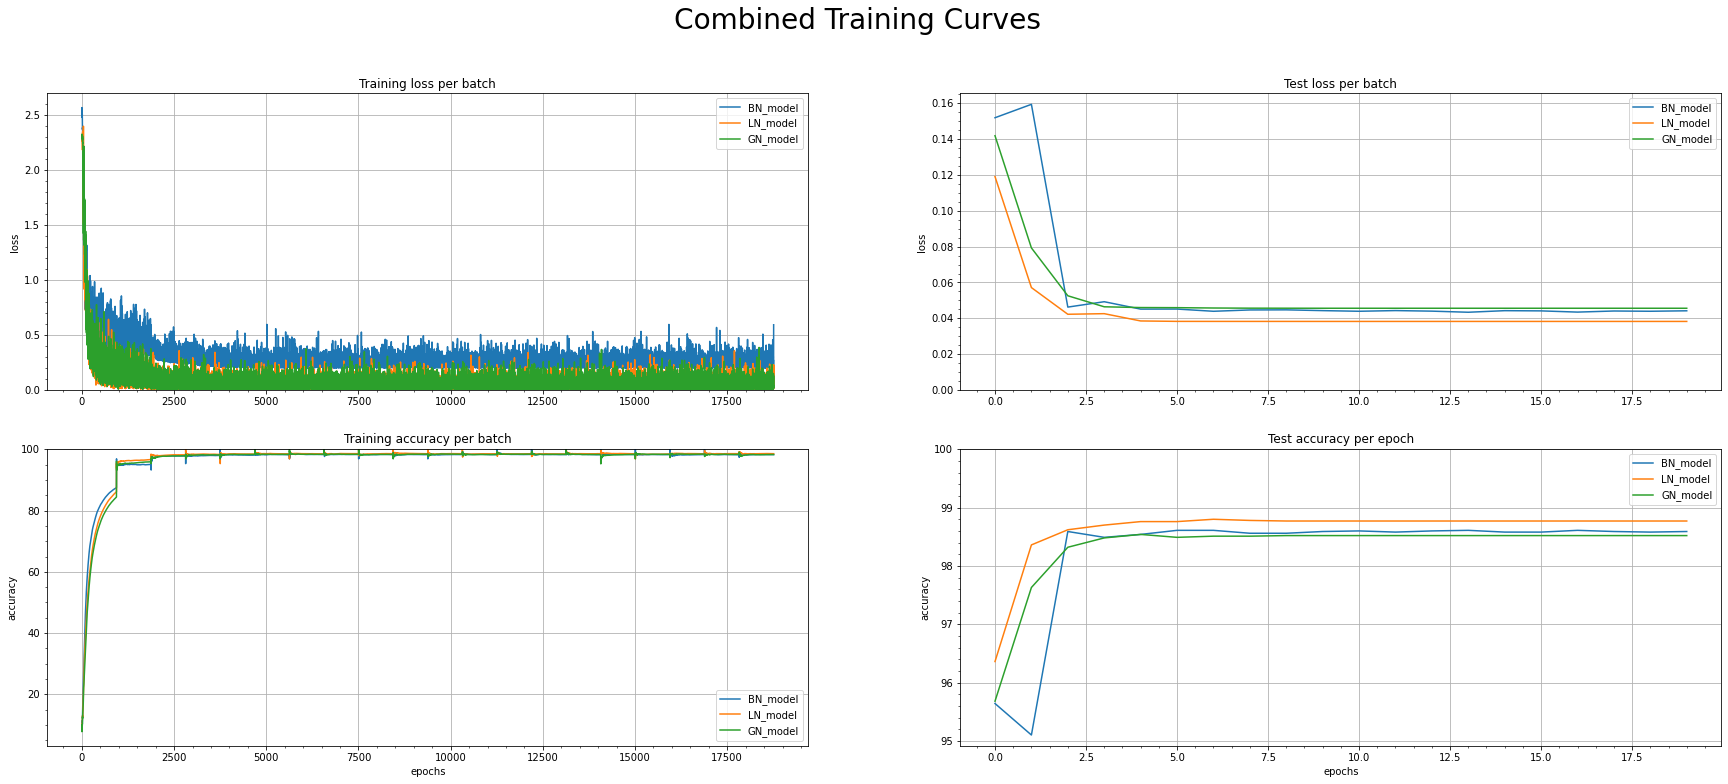

In [10]:
training_curves(history)

# Check Misclassified Images

In [11]:
def plot_misclassified_images(img_data, img_name, count):
  figure = plt.figure(figsize=(10, 10))
  num_of_images = len(img_data)
  for index in range(1, count + 1):
      plt.subplot(5, np.ceil(count/5), index)
      plt.axis('off')
      plt.imshow(img_data[index-1]["img"], cmap='gray_r')
      plt.title("Predicted: %s\nActual: %s" % (img_data[index-1]["pred"], img_data[index-1]["target"]))
  plt.tight_layout()
  plt.savefig(img_name)

### L1 + Batch Normalization model

<ipython-input-11-bcbfa1a2ba17>:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(5, np.ceil(count/5), index)


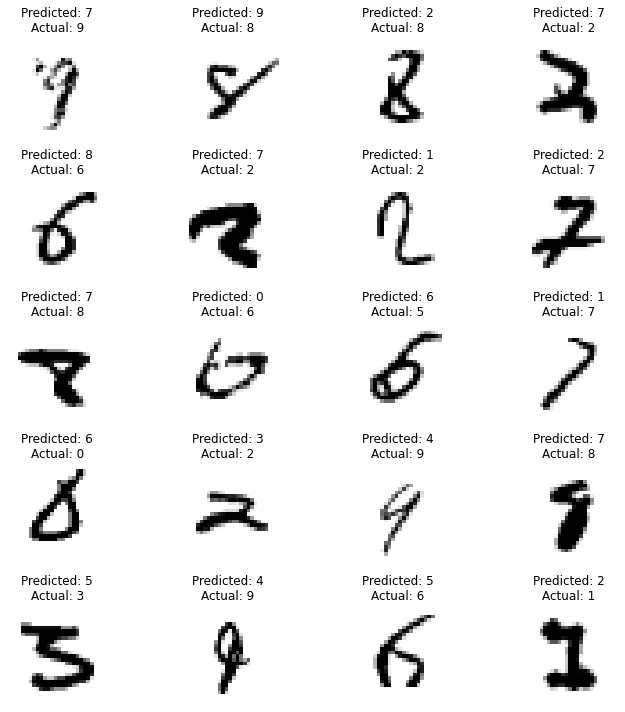

In [12]:
plot_misclassified_images(history['BN_model']['misclassified_imgs'], "misclassified_imgs_BN.png", 20)

### Group Normalization model

<ipython-input-11-bcbfa1a2ba17>:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(5, np.ceil(count/5), index)


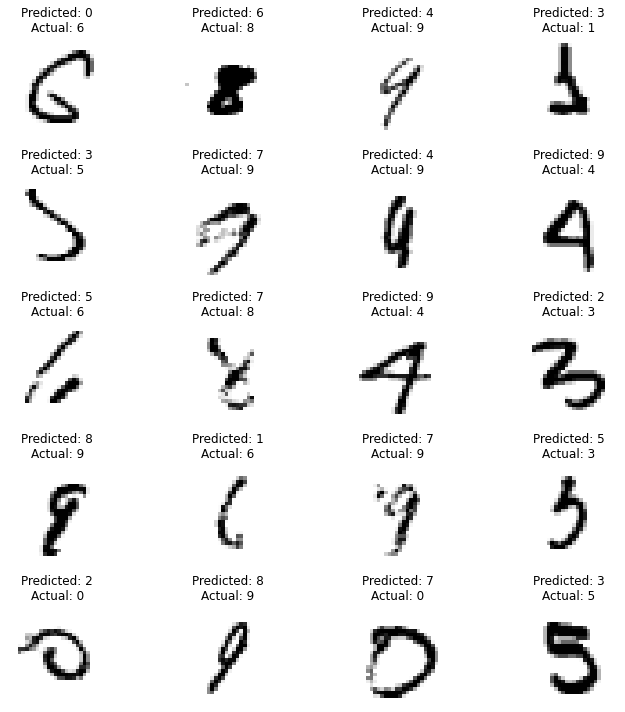

In [13]:
plot_misclassified_images(history['GN_model']['misclassified_imgs'], "misclassified_imgs_GN.png", 20)

### Layer Normalization model

<ipython-input-11-bcbfa1a2ba17>:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(5, np.ceil(count/5), index)


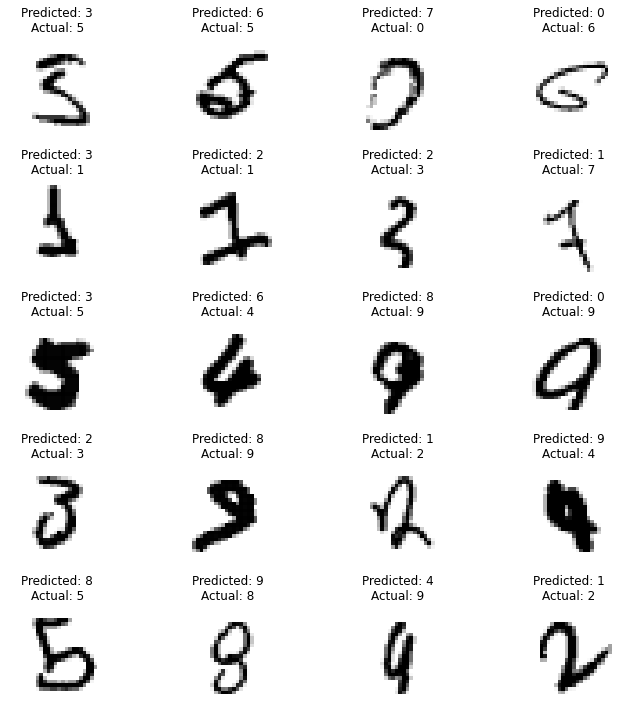

In [14]:
plot_misclassified_images(history['LN_model']['misclassified_imgs'], "misclassified_imgs_LN.png", 20)